#Import Libraries


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap

# Task 1- Describe the Dataset


In [ ]:
# Task 1- Describe the Dataset
df= pd.read_csv('bankloan.csv')
print(df.head())
print("\n")
print(df.describe())

# Use the Profile for reporting.
#profile= ProfileReport(df, title="Pandas Profiling Report")
#profile.to_file("report.html")

   Row ID        id  member_id  loan_amnt  funded_amnt        term  int_rate  \
0     1.0  60516983   64537751      20000        20000   36 months     12.29   
1     2.0  60187139   64163931      11000        11000   36 months     12.69   
2     3.0  60356453   64333218       7000         7000   36 months      9.99   
3     4.0  59955769   63900496      10000        10000   36 months     10.99   
4     5.0  58703693   62544456       9550         9550   36 months     19.99   

   installment grade sub_grade  ... application_type annual_inc_joint  \
0       667.06     C        C1  ...       INDIVIDUAL              NaN   
1       369.00     C        C2  ...       INDIVIDUAL              NaN   
2       225.84     B        B3  ...       INDIVIDUAL              NaN   
3       327.34     B        B4  ...       INDIVIDUAL              NaN   
4       354.87     E        E4  ...       INDIVIDUAL              NaN   

  dti_joint  acc_now_delinq tot_coll_amt tot_cur_bal total_rev_hi_lim  \
0      

# Task 2 - Subtask 1

The minimum value in this feature: "loan_amount", that dashboard prints is the 1000, while the maximum is 35000 and the mean is 15257.966.

# Subtask 2
The whole dataset contains 53 distinct features. Many of them are not actualy usefull for a model in machine learning. Specifically, features that contains diplicate information, features that do not provide any helpful information such as **Row id, id, member id**.

Moreover, it is important to remove any features that can provide to the model "future" information, which will end to **data leakage** through the training. For instance using the bankloan dataset, it is crucial to remove any feature that provide information after the loan was granted. Such features are **last_pymnt_d, last_pymnt_amn, total_pymnt, out_prncp, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, next_pymnt_d , last_credit_pull_d**. In additional, features that contain text variables related to towns, titles, name of the Banks etc. In particular **title and emp_tile** will also removed.

Furthermore, features that the majority of their values are Nan, can not been used to improve the model prediction or classification task, so they will also been removed. These variables from dashboard and pandas output are **Unnamed, Row ID	,dti_joint,	annual_inc_joint, 36months,	60months,mths_since_last_major_derog, mths_since_last_delinq**. As for the remaining features that contains 5% Nan values, there are several techniques to handle these missing values, like interpolation or insert the previous values, or even throw them away.

Last but not least, variables like the **application_type,collections_12_mths_ex_med, acc_now_delinq, tot_coll_amt which** has almost zero variance are not important also for a machine learning task, so they will also removed.

In [ ]:
(df.isna().mean().sort_values(ascending=False) * 100).head(10)

,0
Unnamed: 50,100.000000
Row ID,99.827229
dti_joint,99.793896
annual_inc_joint,99.792957
36months,99.760093
60months,99.760093
mths_since_last_major_derog,70.720520
mths_since_last_delinq,48.531214
emp_title,6.004723
emp_length,5.993925


In [ ]:
# Throw them away from initial dataframe
drop_cols = [
    # identifiers
    "Row ID", "id", "member_id","funded_amnt","term",
    "emp_length","verification_status","purpose","issue_d",

    # leakage features
    "last_pymnt_d", "last_pymnt_amnt",
    "out_prncp", "total_rec_prncp",
    "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries",
    "collection_recovery_fee", "next_pymnt_d",
    "last_credit_pull_d",

    # high missingness
    "Unnamed: 50", "dti_joint", "annual_inc_joint",
    "36months", "60months",
    "mths_since_last_major_derog", "mths_since_last_delinq",
    "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt",

    # high-cardinality text
    "title", "emp_title", "application_type"
]

df_clean = df.drop(columns=drop_cols)
print(f"The new shape of the DataFrame is: {df_clean.shape}")

print(df_clean.head())

# Save the new Dataframe
df_clean.to_csv("bankloan_clean.csv", index=False)

The new shape of the DataFrame is: (212999, 21)
   loan_amnt  int_rate  installment grade sub_grade home_ownership  \
0      20000     12.29       667.06     C        C1            OWN   
1      11000     12.69       369.00     C        C2       MORTGAGE   
2       7000      9.99       225.84     B        B3       MORTGAGE   
3      10000     10.99       327.34     B        B4       MORTGAGE   
4       9550     19.99       354.87     E        E4           RENT   

   annual_inc  loan_status    dti  delinq_2yrs  ... inq_last_6mths  open_acc  \
0     65000.0  Charged Off  20.72            0  ...              1        25   
1     40000.0  Charged Off  24.57            0  ...              0        13   
2     32000.0  Charged Off  32.41            0  ...              1        18   
3     48000.0  Charged Off  30.98            0  ...              2        18   
4     32376.0  Charged Off  32.54            0  ...              3         9   

   pub_rec  revol_bal  revol_util  total_acc  init

# Apply Preprocessing methods.

In Categorical data i will use **Label Encoding** for all the categorical columns using the pandas library.

In addition, for numerical features i will use scaler, but after i split them to train/test sets, in order to fit the scaler only to train data and transform only the test set.

In [ ]:
# Convert each categorical using One-Hot encoding
cat_cols = df_clean.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)

# Apply Label Encoding to each categorical column
le = LabelEncoder()
for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

# Convert booleans to 0/1
bool_cols = df_clean.select_dtypes(include='bool').columns
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

# Show final dataframe
df_clean.head()
print(df_clean.shape)

Categorical columns: Index(['grade', 'sub_grade', 'home_ownership', 'loan_status',
       'earliest_cr_line', 'initial_list_status'],
      dtype='object')
(212999, 21)


# Subset 4- Create the target column
So far we have two related features:
  grade (A, B, C, D, E, F, G)
  sub_grade (A1, A2, A3, B1, B2, B3, …)

Target will be a column with 0 and 1. The **subtarget** column will be used in order to create the target column. If the customer belongs to A1,B1 or B2, then it should get the loan so the label will be 1. The other customers will have label 0.

In [ ]:
# Define the accepted categorical values that will be granted for a loan.
accepted = ["A1","A2","A3","A4","A5", "B1", "B2"]

#Initialize the target column
df["target"] = df["sub_grade"].isin(accepted).astype(int)
df[["sub_grade", "target"]].head(100)

#Now add this column to df_clean
df_clean["target"] = df["target"].values
print(df_clean.head())

   loan_amnt  int_rate  installment  grade  sub_grade  home_ownership  \
0      20000     12.29       667.06      2         10               2   
1      11000     12.69       369.00      2         11               1   
2       7000      9.99       225.84      1          7               1   
3      10000     10.99       327.34      1          8               1   
4       9550     19.99       354.87      4         23               3   

   annual_inc  loan_status    dti  delinq_2yrs  ...  open_acc  pub_rec  \
0     65000.0            0  20.72            0  ...        25        0   
1     40000.0            0  24.57            0  ...        13        1   
2     32000.0            0  32.41            0  ...        18        0   
3     48000.0            0  30.98            0  ...        18        0   
4     32376.0            0  32.54            0  ...         9        0   

   revol_bal  revol_util  total_acc  initial_list_status  total_pymnt  \
0      31578        77.0         42        

# Subtask 5
Find the percentage of the individuals which have 15% and more propability to be accepted to get the loan.

Bellow code, split the dataframe to intervals with different loan amounts. For all the intervals except the last one which is from [30000, 35000], all the loans should be granted.

In [ ]:
# Split the initial values to the specific range of values
intervals = range(0, df_clean["loan_amnt"].max() + 5000, 5000)
df_clean["loan_bin"] = pd.cut(df_clean["loan_amnt"], bins=intervals)
df_clean.groupby("loan_bin")["target"].mean()



/tmp/ipython-input-333031255.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("loan_bin")["target"].mean()


,target
loan_bin,
"(0, 5000]",0.248018
"(5000, 10000]",0.352425
"(10000, 15000]",0.290306
"(15000, 20000]",0.282640
"(20000, 25000]",0.283728
"(25000, 30000]",0.279096
"(30000, 35000]",0.127053


# Task 3 - Classification

Before applying the scaler to the Dataframe, i am gonna split the dataframe to traing and test sets, to avoid fitting the scaler to the whole dataframe, as so to the test set. Otherwise, the model will see the statistical metrics from the test set and will cheat due to the information leakage.

In [ ]:
# Split the Dataframe to Train & Test sets
# The reasons that i dropped also the grade and sub_grade columns are explained below.
X = df_clean.drop(columns=["target", "loan_bin","grade", "sub_grade", "loan_status", "total_pymnt","initial_list_status", "int_rate"])
print(X.columns)
y = df_clean["target"]
seed=0
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30,random_state=seed,stratify=y)
# Fill any remaining NaN using linear interpolation.
X_train = X_train.interpolate(method='linear', axis=0)
X_test = X_test.interpolate(method='linear', axis=0)

# Normalization.
# New dataframe contains only numerical values, the categorical features have been transformed to numbers using the one-hot encoding.
# As for numerical values, the Standarscaler is not ideal for this instance, because the loan amounts acts as outliers compared to other numerical values.
# For this dataset, the scaler will be the Robust Scaler which handles the outliers.
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train has shape: {X_train_scaled.shape}")
print(f"X_test has shape: {X_test_scaled.shape}")

Index(['loan_amnt', 'installment', 'home_ownership', 'annual_inc', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')
X_train has shape: (149099, 15)
X_test has shape: (63900, 15)


# Subtask 1 - Apply a Classification Algorithm.

Current dataset and task ask to apply a machine learning classifier, usign the target column as "target". This is a binary classification problem with two classes. I will choose **Logistic Regression** to test it on this dataset. It can be explained, it is stable and very fast and performs well in large datasets. **Desicion Tree and Random forest** do not requires so it out of the equation. SVM with 20k samples requires significant amound of time to be fitted and test it on test data.

The features that can expose the target to the model, are the ones who used to create the target column. So the **grade**, **sub_grade**, **loan_status** and **int_rate** need to be removed, otherwise the model will know the exactly class of the individual and classifies him. This mistake will lead to 100% performance without any error, which is not desirable. The important columns that need to be removed have already removed in the above cell.

In [ ]:
# Hyperparameters Tuning, to find the best parameters for LogisticRegression for this case.
# The logigist regression is very sensitive to C. So we will test a many different C.
# C defines the complexity of the model, by controlling it we can have better results in both Precision and Recall

#Define the Hyperparameter variables
param_grid = {"C": [0.01, 0.1, 1, 5, 10]}
#Initialize the model
log_reg = LogisticRegression(max_iter=1000,solver="liblinear",class_weight="balanced")
#Use F1-score because if the best for imbalanced datasets
# 5-fold cross validation
grid = GridSearchCV(estimator=log_reg,param_grid=param_grid,scoring="f1",cv=5,n_jobs=-1)
grid.fit(X_train, y_train)

print("Best C:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)


Best C: {'C': 10}
Best CV F1 Score: 0.5536540249502034


In [ ]:
# Define the classifier and fit to the Train_Dataset
# Use the most appropriate parameters from Cross-Validation, to define the final model.
best_C = grid.best_params_["C"]
classifier= LogisticRegression(C= best_C, max_iter=1000, solver="liblinear", class_weight="balanced")
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"Recall    : {recall*100:.2f}%")
print(f"F1 Score  : {f1*100:.2f}%")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy  : 70.22%
Precision : 48.62%
Recall    : 61.25%
F1 Score  : 54.21%

Classification report:

              precision    recall  f1-score   support

           0       0.83      0.74      0.78     45513
           1       0.49      0.61      0.54     18387

    accuracy                           0.70     63900
   macro avg       0.66      0.68      0.66     63900
weighted avg       0.73      0.70      0.71     63900



**Recall** is the most important metric in this case, because it shows how many of the customers who were approved to loan, were actually the desired (true positive) ones. This metric, also show how the risk is mitigated by choosing the correct customers.

Precision is far more important than accuracy, because it shows how many customers, who were approved to get the loan are actually good and will return the loan.

F1-score provides a more generic information, which contains the recall and precision. Its very usefull for imbalanced datasets.

Accuracy is not the most important metric here, due to the class imbalanced.

Overall, the model did capture the hidden patterns clasifying the most of the test samples in correct class. Therefore, it is noticable that the degration from **53 features to 15 features**, didnt thrown away much important information, and this argument is it verified in the above metrics.

# Task 4 - Random Forest


In [ ]:
#Define the RnadomForest classifier
seed=0
random_forest = RandomForestClassifier(n_estimators=100,random_state=seed,class_weight="balanced")
# Fit the classifier to the Train Data
random_forest.fit(X_train, y_train)

# Predictions & metrics
random_forest_pred = random_forest.predict(X_test)

# Predictions
accuracy  = accuracy_score(y_test, random_forest_pred)
precision = precision_score(y_test, random_forest_pred)
recall    = recall_score(y_test, random_forest_pred)
f1        = f1_score(y_test, random_forest_pred)

print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"Recall    : {recall*100:.2f}%")
print(f"F1 Score  : {f1*100:.2f}%")
print("\nClassification report:\n")
print(classification_report(y_test, random_forest_pred))


Accuracy  : 83.69%
Precision : 82.75%
Recall    : 54.75%
F1 Score  : 65.90%

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     45513
           1       0.83      0.55      0.66     18387

    accuracy                           0.84     63900
   macro avg       0.83      0.75      0.78     63900
weighted avg       0.84      0.84      0.83     63900



# Feature Importance

Bellow visualization depicts the most significant features. But, the x-axis shows that even the most important feature have small influence (0.14) to the decisions of the algorithm.

/tmp/ipython-input-3497586034.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15,x="importance",y="feature",palette="viridis")


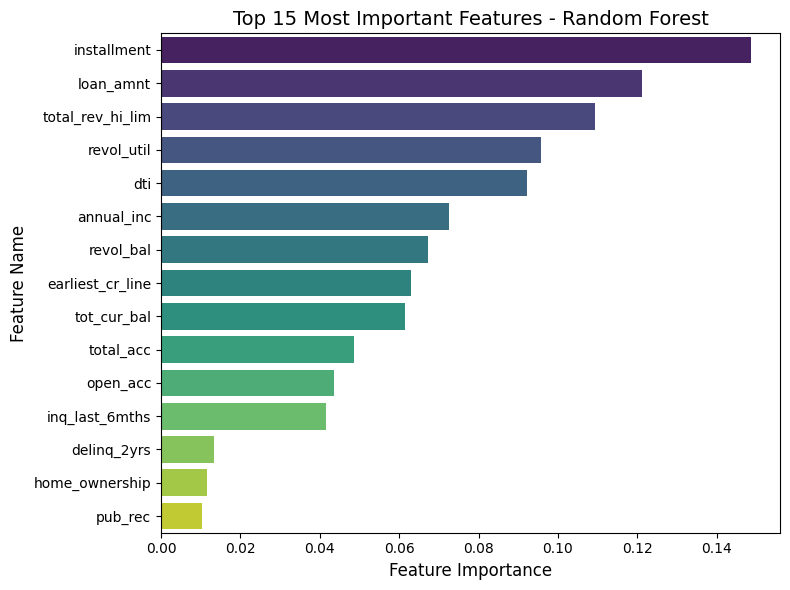

             feature  importance
1        installment    0.148514
0          loan_amnt    0.121127
14  total_rev_hi_lim    0.109349
11        revol_util    0.095796
4                dti    0.092288
3         annual_inc    0.072494
10         revol_bal    0.067264
6   earliest_cr_line    0.062889
13       tot_cur_bal    0.061364
12         total_acc    0.048703
8           open_acc    0.043605
7     inq_last_6mths    0.041655
5        delinq_2yrs    0.013257
2     home_ownership    0.011487
9            pub_rec    0.010207


In [ ]:
importances = random_forest.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_train.columns,'importance': importances})

# Sort by importance
top15 = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=top15,x="importance",y="feature",palette="viridis")

plt.title("Top 15 Most Important Features - Random Forest", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.tight_layout()
plt.show()
print(top15)

# Correlation Matrix between the top 15 important features

Bellow visualization shows the correlation between the most important features. It is anticipated the diagonial to present the higher correlation, due to the similar feature. The majority of the cells except from the diagonial are blue, which shows the small correlation between distinct features. There are some features which seems correlated such as **revol_bal with total_rev_in_lim and loan_amnt with installment and open_acc with total_acc**.

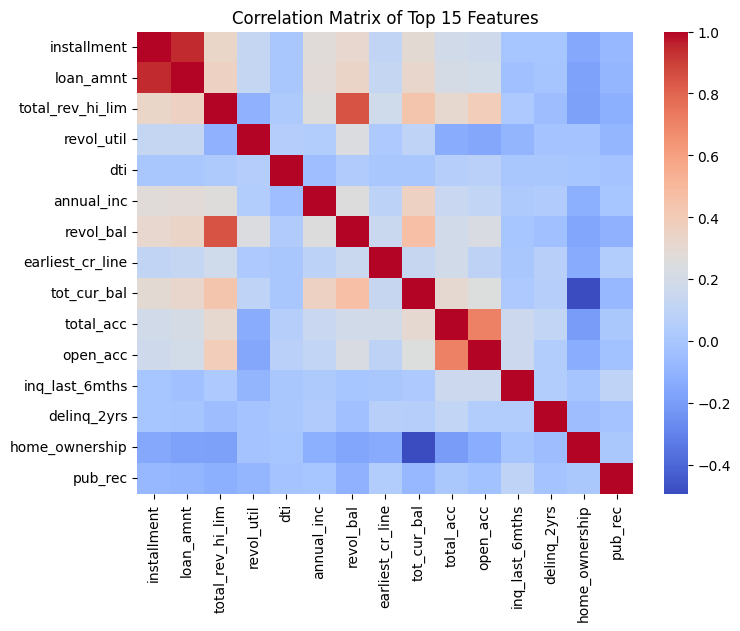

In [ ]:
top15_features = top15['feature'].tolist()
corr_matrix = df_clean[top15_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of Top 15 Features")
plt.show()

In [ ]:
# Keep the lowest correlated features and train again the Random forest.
#Initialize an empty list
low_corr_features = []
#Find the features with the smaller correlation
# Since, the correlation is ranged from [0,1] we will keep the features that have correlation<0.5
for feat in top15_features:
    correlations = corr_matrix[feat].drop(feat)
    # Keep features with abs corr < 0.5 with all others
    if all(abs(correlations) <= 0.5):
        low_corr_features.append(feat)

print("Low-correlation features kept:", low_corr_features)

Low-correlation features kept: ['revol_util', 'dti', 'annual_inc', 'earliest_cr_line', 'tot_cur_bal', 'inq_last_6mths', 'delinq_2yrs', 'home_ownership', 'pub_rec']


# Train the Random Forest using only the features with the smallest correlations

In [ ]:
X_train_low = X_train[low_corr_features]
X_test_low  = X_test[low_corr_features]
seed=0
random_forest = RandomForestClassifier(n_estimators=100,random_state=seed,class_weight="balanced")

# Fit the classifier to the Train Data
random_forest.fit(X_train_low, y_train)
# Predictions & metrics
y_pred_low=random_forest_pred = random_forest.predict(X_test_low)

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_test, y_pred_low))
print("Precision:", precision_score(y_test, y_pred_low))
print("Recall:", recall_score(y_test, y_pred_low))
print("F1 Score:", f1_score(y_test, y_pred_low))
print("\nClassification report:\n")
print(classification_report(y_test, random_forest_pred))

Accuracy: 0.7394992175273866
Precision: 0.5934113102264191
Recall: 0.3007559688910643
F1 Score: 0.3991915108640728

Classification report:

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     45513
           1       0.59      0.30      0.40     18387

    accuracy                           0.74     63900
   macro avg       0.68      0.61      0.62     63900
weighted avg       0.72      0.74      0.71     63900



The results are far worse than using all the features from the new dataframe, and is it reasonable.

# Task 5 - Load the Mnist Binary Dataset


# Subtask 1

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train set shape :", x_train.shape)
print("Test set shape  :", x_test.shape)
print("Train labels    :", y_train.shape)
print("Test labels     :", y_test.shape)

# Flatten the Train and test matrices.

N = x_train.shape[0]
X_train_vector = x_train.reshape(N,-1)
X_test_vector = x_test.reshape(x_test.shape[0],-1)

print(f"The shape of the X train Vector is:, {X_train_vector.shape}")
print(f"The shape of the X test Vector is:, {X_test_vector.shape}")

Train set shape : (60000, 28, 28)
Test set shape  : (10000, 28, 28)
Train labels    : (60000,)
Test labels     : (10000,)
The shape of the X train Vector is:, (60000, 784)
The shape of the X test Vector is:, (10000, 784)


# Subtask 2 - Standar Scaler to the vectors


In [ ]:
scaler=StandardScaler()

# Fit the scaler only to data
X_train_vector_scaled=scaler.fit_transform(X_train_vector)

# Only Transform the X_test
X_test_vector_scaled=scaler.transform(X_test_vector)

# Sybstask 3 -  PCa with 300 components. The total dimensions will be reduced from 784 to 300.

It is logical to apply fit and transform only to the X_train data, otherwise pca will also use the covariance of the X_test vectors. Then the test set will be projected to different axes. To conclude this argument again will be leak test information into the model if i combine X_train and X_test and apply to the aggregated X PCA.


In [ ]:
# Keep 300 components
pca = PCA(n_components=300)

#Fit the method to X_train
X_train_pca = pca.fit_transform(X_train_vector_scaled)
X_test_pca  = pca.transform(X_test_vector_scaled)

print("X_train PCA shape:", X_train_pca.shape)
print("X_test PCA shape :", X_test_pca.shape)

# Total information that will be lost, from the dimensionality reduction.
# PCA finds the best component, by calculating the eigenvectors of the covariance between the differnent features.
# So we keep the 300 most imporntant components ( eigenvectors) which keep the most imporant features with the biggest covariance.
# We keep the 93% of the total information which is really important for a classification task.
total_variance_retained = pca.explained_variance_ratio_.sum()
print("Variance retained:", total_variance_retained)
print("Information lost:", 1 - total_variance_retained)

X_train PCA shape: (60000, 300)
X_test PCA shape : (10000, 300)
Variance retained: 0.9379126057657093
Information lost: 0.06208739423429066


# Apply KNN to the data



 Knn with k: 5
 Knn with k: 15
 Knn with k: 51
 Knn with k: 101


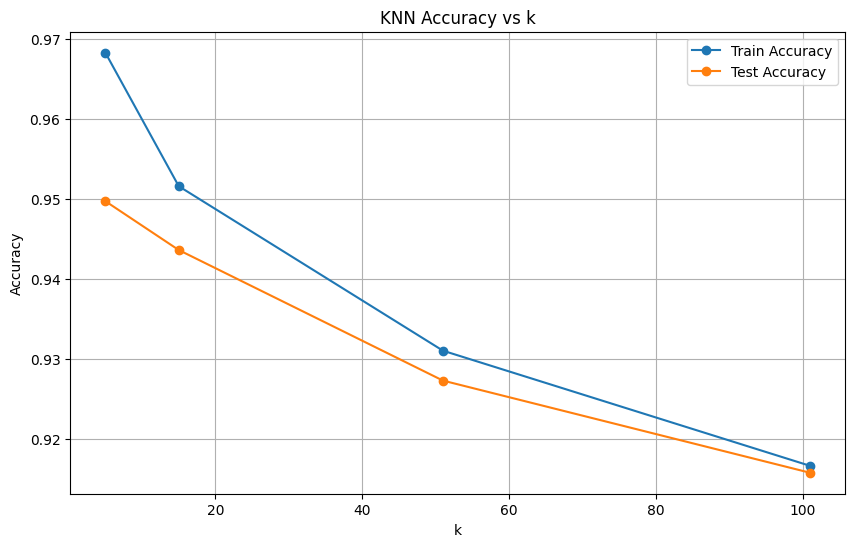

In [ ]:
k_values=[5,15,51,101]
best_knn = None
best_k = None
best_test_accuracy = -1

# Initialize the train_accuracy, test_accuracy lists, to store the accuracy for each experiment.
train_accuracy=[]
test_accuracy=[]

for k in k_values:
  # fit each knn algorithm to the train data
  # n_jobs =-1 uses all the cpu cores, to make faster the process of the algorithm
  print(f" Knn with k: {k}")
  knn=KNeighborsClassifier(n_neighbors=k, algorithm='auto', metric='euclidean', n_jobs=-1)

  # Knn is lazy algorithm, fitting is typical the term, which the algorithm is applied to the train data, is not learning anything or actually training.
  knn.fit(X_train_pca, y_train)


  # Store the accuracy for both train, test sets
  y_train_pred_scaled=knn.predict(X_train_pca)
  train_accuracy.append(accuracy_score(y_train,y_train_pred_scaled))

  # Becasue the algorithm have to calculate the distances of all the 10000 test samples with the training samples in 784 dimensions.
  y_test_pred_scaled=knn.predict(X_test_pca)
  test_acc = accuracy_score(y_test, y_test_pred_scaled)
  test_accuracy.append(test_acc)

  #Store only the best version of knn with different k
  if test_acc > best_test_accuracy:
    best_test_accuracy= test_acc
    best_k=k
    best_knn=knn

#Plot the accuracy scores for each experiment
plt.figure(figsize=(10,6))
plt.plot(k_values, train_accuracy, marker='o', label='Train Accuracy')
plt.plot(k_values, test_accuracy, marker='o', label='Test Accuracy')

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k")
plt.grid(True)
plt.legend()
plt.show()

# Task 4 - LDA - 2 Dimensions

In [ ]:
# Define the LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
# Fit and transform to the vectors
X_train_lda = lda.fit_transform(X_train_vector_scaled, y_train)
X_test_lda  = lda.transform(X_test_vector_scaled)

#print the dimensions after the LDA,
print("LDA train shape:", X_train_lda.shape)
print("LDA test shape :", X_test_lda.shape)

LDA train shape: (60000, 2)
LDA test shape : (10000, 2)


# Visualize the differnet classes to 2 dimensions

Using LDA to reduce the dimensions from 784 to 2, the largest part of the information is lost. Most classes overlap with each other, and distinguishing them with eyes becomes impossible.

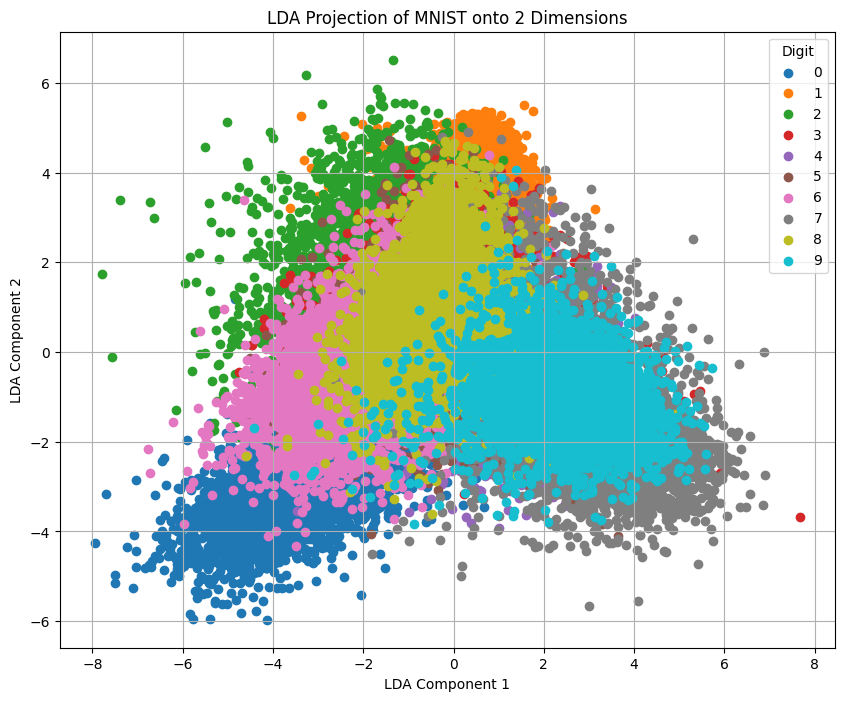

In [ ]:
plt.figure(figsize=(10, 8))

for digit in np.unique(y_train):
    idx = y_train == digit
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], label=str(digit))

plt.title("LDA Projection of MNIST onto 2 Dimensions")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(title="Digit")
plt.grid(True)
plt.show()

# Task 5

In [ ]:
umap_reducer = umap.UMAP(n_components=2,n_neighbors=15,min_dist=0.1,metric="euclidean",random_state=0)

# Fit on training data only
X_train_umap = umap_reducer.fit_transform(X_train_vector_scaled)

# Transform test data (do NOT fit again)
X_test_umap = umap_reducer.transform(X_test_vector_scaled)

print("UMAP train shape:", X_train_umap.shape)
print("UMAP test shape:", X_test_umap.shape)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP train shape: (60000, 2)
UMAP test shape: (10000, 2)


# Visualize the Umap

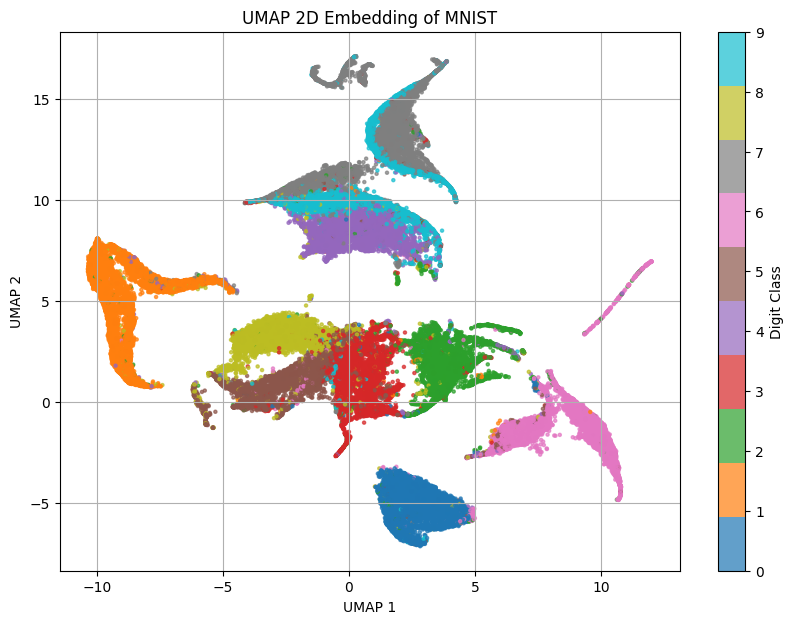

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1],c=y_train,cmap="tab10",s=5,alpha=0.7)

plt.title("UMAP 2D Embedding of MNIST")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Digit Class")
plt.grid(True)
plt.show()

# Comparison between LDA and UMAP
LDA is a linear dimensionality reduction, it tries to project the data onto directions that maximize class separation. Specifically, the MNIST dataset is nonlinear dataset so the separation cant been achieved. Moreover from 784 to 2 dimension most of the information and characteristic of the dataset is lost.

On the other hand, the UMAP is a non-linear dimensionality reduction method. Using some arguments like local neighborhoogs we can distinguish the local information from the global information, which focus on local structure and tight clusters rathen than one big cluster. Additionally, the above visualization captures the pattern of the different clusters more effectively, and the clusters can be separated and intentified with the eyes. Of course, information is lost too, using Umap, but the result is better in nonlienar datasets.